# Etapa 3

## 1. Procesar archivos

In [ ]:
# Importación de librerías necesarias
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

# Ruta donde se almacenan los datos procesados
processed_file_path = '../data/ecgs_procesados.csv'

# Si el archivo procesado ya existe, se carga directamente
if os.path.exists(processed_file_path):
    print("📄 Cargando datos ya procesados desde ecgs_procesados.csv...")
    df = pd.read_csv(processed_file_path)
    df = df[df['label'].isin(['Normal', 'AFib'])]  # Filtra solo clases Normal y AFib

else:
    # Si no existe el archivo procesado, se cargan los datos crudos para procesarlos

    # Ruta al archivo con etiquetas de clase (REFERENCE.csv)
    ref_path = '../data/archivos/REFERENCE.csv'
    labels_df = pd.read_csv(ref_path, header=None, names=['record', 'label'])

    # Filtrar solo registros con etiquetas N (Normal) o A (AFib)
    labels_df = labels_df[labels_df['label'].isin(['N', 'A'])]

    data_path = '../data/archivos/'
    features = []

    # Iterar sobre cada registro etiquetado
    for _, row in labels_df.iterrows():
        record_name = row['record']
        label_code = row['label']
        record_path = os.path.join(data_path, record_name)

        try:
            # Cargar la señal usando wfdb
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal[:, 0]  # Tomar solo el primer canal

            # Normalizar la señal
            signal_norm = (signal - np.mean(signal)) / np.std(signal)

            # Detección de picos R
            peaks, _ = find_peaks(signal_norm, distance=200, height=0.5)
            rr_intervals = np.diff(peaks)

            if len(rr_intervals) < 3:
                continue  # Saltar señales con pocos picos

            # Extraer características
            mean_rr = np.mean(rr_intervals)
            std_rr = np.std(rr_intervals)
            skew_rr = skew(rr_intervals)
            kurt_rr = kurtosis(rr_intervals)

            # Convertir etiqueta
            label = {'N': 'Normal', 'A': 'AFib'}[label_code]

            # Agregar a la lista
            features.append([mean_rr, std_rr, skew_rr, kurt_rr, label])

        except Exception as e:
            print(f"❌ Error procesando {record_name}: {e}")
            continue

    # Crear DataFrame con los resultados
    df = pd.DataFrame(features, columns=['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr', 'label'])

    # Guardar CSV con las características extraídas
    output_path = '../data/ecgs_procesados.csv'
    df.to_csv(output_path, index=False)
    print(f"✅ ECGs procesados guardados en {output_path}")


✅ ECGs procesados guardados en ../data/ecgs_procesados.csv


Distribución de clases

C:\Users\yanko\AppData\Local\Temp\ipykernel_804\76478376.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


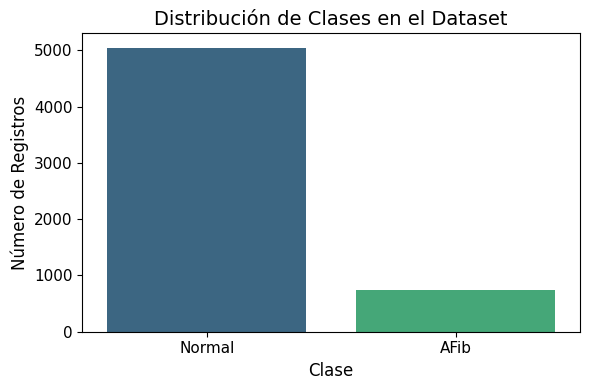

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de clases
class_counts = df['label'].value_counts()

# Gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Distribución de Clases en el Dataset", fontsize=14)
plt.xlabel("Clase", fontsize=12)
plt.ylabel("Número de Registros", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


## 2. Separar variables predictoras y variable objetivo

In [3]:
X = df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = df['label']

## 3. Dividir el dataset en entrenamiento y prueba

In [4]:
from sklearn.model_selection import train_test_split

#Dividir el dataset en 70% para entrenamiento y 30% para pruebas.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## 4. Escalar los datos

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)    

## 5. Entrenamiento de modelo base con MLP (Perceptrón Multicapa)

In [6]:
from sklearn.neural_network import MLPClassifier

# Definir el modelo MLP con una arquitectura de dos capas ocultas (128 y 64 neuronas)
modelo = MLPClassifier(
    hidden_layer_sizes=(128, 64),    # Tamaño de las capas ocultas
    max_iter=1000,                   # Número máximo de iteraciones
    random_state=42,                 # Semilla para reproducibilidad
    solver='adam',                   # Optimizador (Adam)
    learning_rate='adaptive',       # La tasa de aprendizaje se ajusta en el entrenamiento
    alpha=0.0001,                    # Parámetro de regularización L2 (evita overfitting)
    activation='relu',              # Función de activación ReLU
    early_stopping=False            # No se detiene anticipadamente, entrena todas las iteraciones
)

# Entrenamiento del modelo con el conjunto de entrenamiento escalado
modelo.fit(X_train_scaled, y_train)

# Predicción de las etiquetas para el conjunto de prueba escalado
y_pred = modelo.predict(X_test_scaled)

## 6. Evaluar el desempeño del modelo

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9073
Precision: 0.7915
Recall: 0.7904
F1-Score: 0.7909


## 7. Matriz de confusión

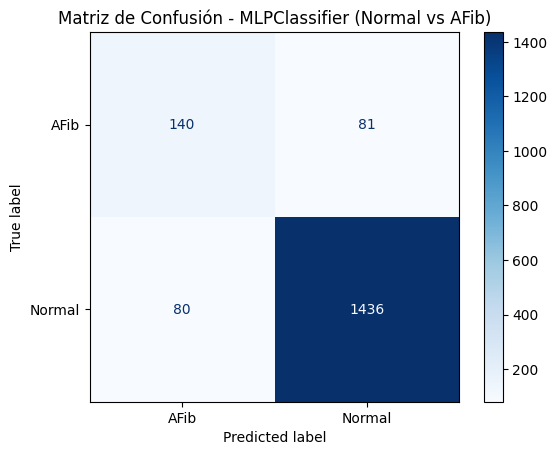

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = sorted(y_test.unique())
disp = ConfusionMatrixDisplay.from_estimator(
    modelo,
    X_test_scaled,
    y_test,
    cmap='Blues',
    labels=labels
)

disp.ax_.grid(False)
plt.title("Matriz de Confusión - MLPClassifier (Normal vs AFib)")
plt.show()


## 8. Reporte completo

In [9]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

        AFib       0.64      0.63      0.63       221
      Normal       0.95      0.95      0.95      1516

    accuracy                           0.91      1737
   macro avg       0.79      0.79      0.79      1737
weighted avg       0.91      0.91      0.91      1737



## Conclusiones de la etapa 3

Se incluyen en el README del proyecto.
